In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

from codecarbon import EmissionsTracker

c:\Users\F8091795\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\F8091795\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\F8091795\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/cor

In [4]:
df = pd.read_csv('Interpolado_jacarepagua.csv', sep=',', encoding='utf8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68405 entries, 0 to 68404
Data columns (total 18 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       68405 non-null  float64
 1   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  68405 non-null  float64
 2   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        68405 non-null  float64
 3   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       68405 non-null  float64
 4   RADIACAO GLOBAL (Kj/m²)                                68405 non-null  float64
 5   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           68405 non-null  float64
 6   TEMPERATURA DO PONTO DE ORVALHO (°C)                   68405 non-null  float64
 7   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)             68405 non-null  float64
 8   TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)    

In [5]:
X_prec = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_prec = df[['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']]

In [7]:

X_temp = df[[
       'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_temp = df[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']]

In [54]:
X_umid = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_umid = df[['UMIDADE RELATIVA DO AR, HORARIA (%)']]

In [9]:
def split_train_test(X, y, train_size):
    X_train, X_test = X[:round(X.shape[0]*train_size)], X[round(X.shape[0]*train_size):]
    y_train, y_test = y[:round(y.shape[0]*train_size)], y[round(y.shape[0]*train_size):]

    return X_train, X_test, y_train, y_test

def plot_prediction_over_time(y_test, predictions, timestamps, start_date=None, end_date=None, save=False):
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_test,
        'Predicted': predictions
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)

    
    if save: 
        plt.savefig(save)
        
    plt.show()


def plot_real_vs_predicted(y_test, predictions, save=False):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Real vs Predicted Values")
    plt.legend()
    plt.grid(True)

    if save: 
        plt.savefig(save)
    
    plt.show()

MLP temperatura

In [10]:
scaler_X = StandardScaler()
X_temp_normalized = scaler_X.fit_transform(X_temp)

scaler_y = StandardScaler()
y_temp_normalized = scaler_y.fit_transform(y_temp)

In [11]:
X_temp_train, X_temp_test, y_temp_train, y_temp_test = split_train_test(X_temp, y_temp, train_size=0.8)


In [12]:
model = tf.keras.Sequential([
    Dense(X_temp.shape[1], activation='relu', input_shape=(X_temp.shape[1], )),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

c:\Users\F8091795\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
tracker = EmissionsTracker(
    project_name="mlp temperature train",
    output_file='./codecarbon_emissions_mlp_temperatura_jacarepagua.csv',
    log_level = "critical"
)

tracker.start()


model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mean_absolute_error'] 
)

model.summary()

model.fit(X_temp_train, y_temp_train, epochs=100, batch_size=32, verbose=1)

loss, mae = model.evaluate(X_temp_test, y_temp_test, verbose=2)
print(f"Loss (MSE): {loss}")
print(f"Mean Absolute Error: {mae}")


rmse = np.sqrt(loss)
print(f"Root Mean Squared Error (RMSE): {rmse}")


emissions: float = tracker.stop()
print(f"emissions={emissions}")

[codecarbon WARNING @ 18:28:03] Multiple instances of codecarbon are allowed to run at the same time.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549 (2.14 KB)

 Trainable params: 549 (2.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 382.5674 - mean_absolute_error: 5.9835  
Epoch 2/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.9699 - mean_absolute_error: 2.5286 
Epoch 3/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.9272 - mean_absolute_error: 2.5388
Epoch 4/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 10.8990 - mean_absolute_error: 2.6570
Epoch 5/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 11.6139 - mean_absolute_error: 2.7256
Epoch 6/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 11.3351 - mean_absolute_error: 2.6907
Epoch 7/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 11.4226 - mean_absolute_error: 2.7030
Epoch 8/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 10.7429 - mean_absolute_error: 2.6333
Epoch 9/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 10.2989 - mean_absolute_error: 2.5820
Epoch 10/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 11.0514 - mean_absolute_e

In [14]:
y_temp_pred_probs = model.predict(X_temp_test, verbose=2)


428/428 - 0s - 1ms/step


In [15]:
y_temp_test_flat = y_temp_test.values.flatten()
y_temp_pred_flat = y_temp_pred_probs.flatten()

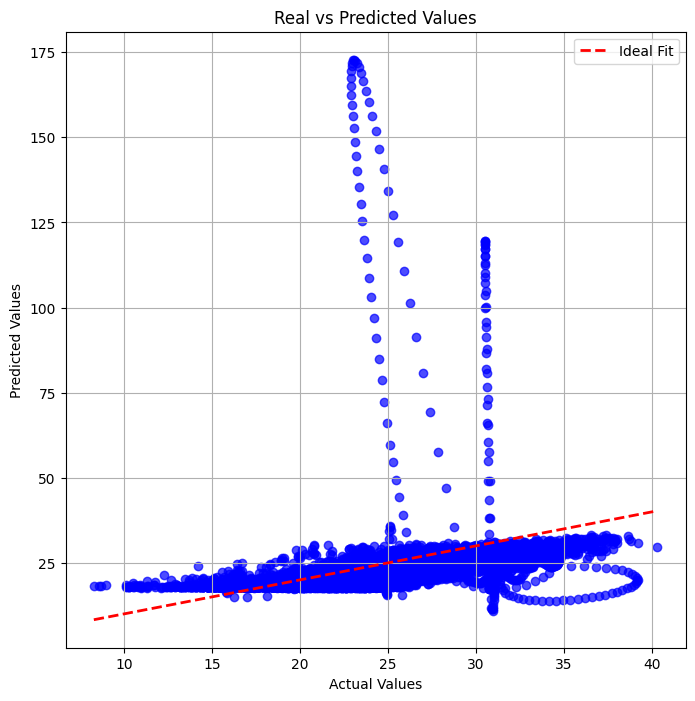

In [ ]:
plot_real_vs_predicted(y_temp_test_flat, y_temp_pred_flat, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\mlp_temp_real_x_pred_jacarepagua.png')


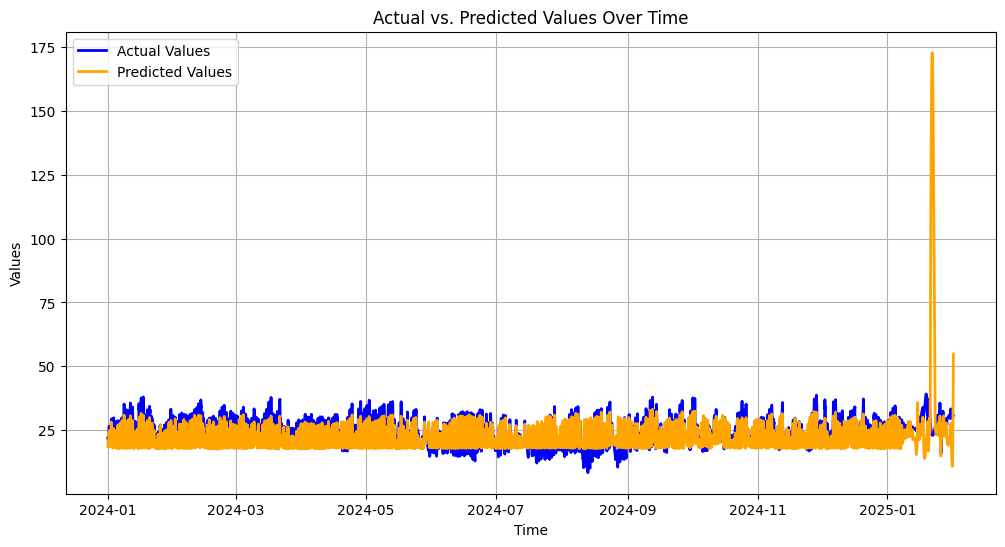

In [34]:
start_date = "2024-01-01 01:00:00"
end_date = "2025-01-31 23:00:00"

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["datetime"]

plot_prediction_over_time(y_temp_test_flat, y_temp_pred_flat, timestamps_test, start_date, end_date, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\mlp_temp_over_time.png')

MLP precipitação

In [39]:
scaler_X = StandardScaler()
X_temp_normalized = scaler_X.fit_transform(X_prec)

scaler_y = StandardScaler()
y_temp_normalized = scaler_y.fit_transform(y_prec)

In [40]:
X_prec_train, X_prec_test, y_prec_train, y_prec_test = split_train_test(X_prec, y_prec, train_size=0.8)


In [41]:
model = tf.keras.Sequential([
    Dense(X_prec.shape[1], activation='relu', input_shape=(X_prec.shape[1], )),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

c:\Users\F8091795\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
tracker = EmissionsTracker(
    project_name="mlp PRECIPITATION 100ep final",
    output_file='./codecarbon_emissions_mlp_temperatura_jacarepagua.csv',
    log_level = "critical"
)

tracker.start()

model.compile(
    loss='mean_squared_error', 
    optimizer='adam',
    metrics=['mean_absolute_error']  
)

model.summary()

model.fit(X_prec_train, y_prec_train, epochs=100, batch_size=32, verbose=1)

loss, mae = model.evaluate(X_prec_test, y_prec_test, verbose=2)
print(f"Loss (MSE): {loss}")
print(f"Mean Absolute Error: {mae}")


rmse = np.sqrt(loss)
print(f"Root Mean Squared Error (RMSE): {rmse}")


emissions: float = tracker.stop()
print(f"emissions={emissions}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849 (3.32 KB)

 Trainable params: 849 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 93.0372 - mean_absolute_error: 3.3897 
Epoch 2/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.0325 - mean_absolute_error: 0.9511
Epoch 3/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.7761 - mean_absolute_error: 0.9112
Epoch 4/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.6985 - mean_absolute_error: 0.9018
Epoch 5/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.7052 - mean_absolute_error: 0.9241
Epoch 6/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.5048 - mean_absolute_error: 0.8446
Epoch 7/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.5773 - mean_absolute_error: 0.8417
Epoch 8/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.2460 - mean_absolute_error: 0.7537
Epoch 9/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.1614 - mean_absolute_error: 0.7292
Epoch 10/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.1556 - mean_absolute_error: 0.71

In [43]:
rmse = np.sqrt(loss)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 6.624708349178092


In [44]:
y_prec_pred_probs = model.predict(X_prec_test, verbose=2)

428/428 - 0s - 655us/step


In [45]:
y_prec_test_flat = y_prec_test.values.flatten()
y_prec_pred_flat = y_prec_pred_probs.flatten()

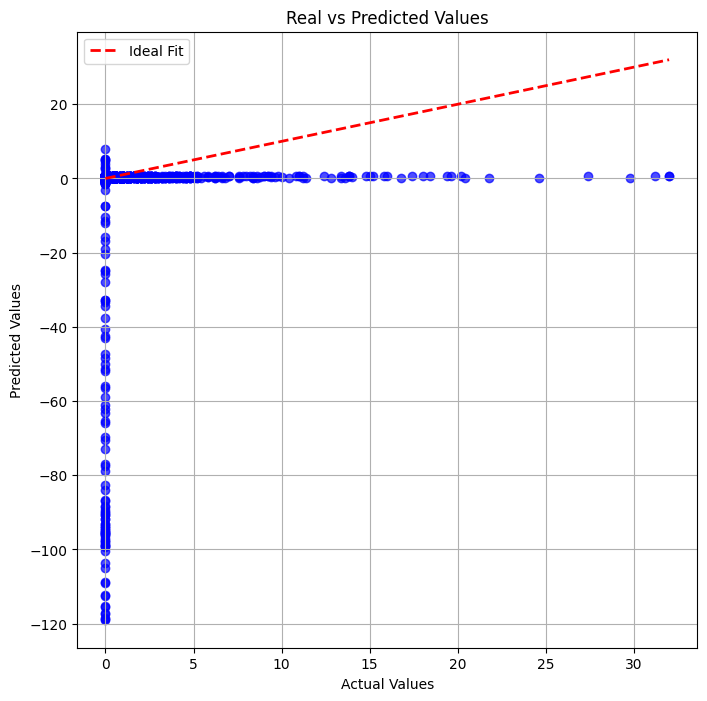

In [46]:
plot_real_vs_predicted(y_prec_test_flat, y_prec_pred_flat, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\mlp_prec_real_x_pred_jacarepagua.png')


FileNotFoundError: [Errno 2] No such file or directory: './images/models/mlp_prec_over_time.png'

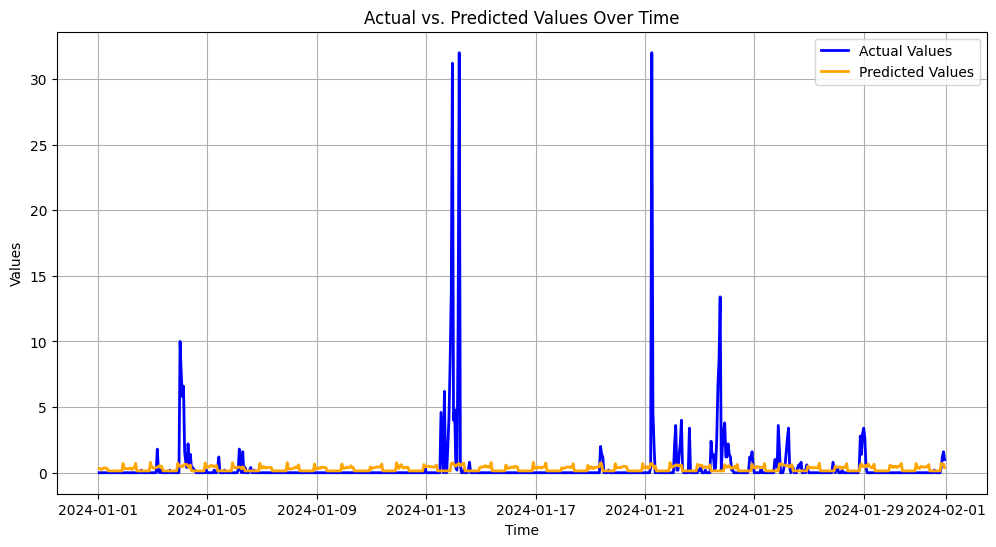

In [49]:
start_date = "2024-01-01 01:00:00"
end_date = "2024-01-31 23:00:00"

timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["datetime"]

plot_prediction_over_time(y_prec_test_flat, y_prec_pred_flat, timestamps_test, start_date, end_date,  save='./images/models/mlp_prec_over_time.png')

MLP umidade

In [55]:
scaler_X = StandardScaler()
X_temp_normalized = scaler_X.fit_transform(X_umid)

scaler_y = StandardScaler()
y_temp_normalized = scaler_y.fit_transform(y_umid)

In [56]:
X_umid_train, X_umid_test, y_umid_train, y_umid_test = split_train_test(X_umid, y_umid, train_size=0.8)


In [60]:
model = tf.keras.Sequential([
    Dense(X_umid.shape[1], activation='relu', input_shape=(X_umid.shape[1], )),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

c:\Users\F8091795\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
tracker = EmissionsTracker(
    project_name="mlp PRECIPITATION 100ep final",
    output_file='./codecarbon_emissions_mlp_temperatura_jacarepagua.csv',
    log_level = "critical"
)

tracker.start()

model.compile(
    loss='mean_squared_error', 
    optimizer='adam',
    metrics=['mean_absolute_error']  
)

model.summary()

model.fit(X_umid_train, y_umid_train, epochs=100, batch_size=32, verbose=1)

loss, mae = model.evaluate(X_umid_test, y_umid_test, verbose=2)
print(f"Loss (MSE): {loss}")
print(f"Mean Absolute Error: {mae}")


rmse = np.sqrt(loss)
print(f"Root Mean Squared Error (RMSE): {rmse}")


emissions: float = tracker.stop()
print(f"emissions={emissions}")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 13)             │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 663 (2.59 KB)

 Trainable params: 663 (2.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3670.1409 - mean_absolute_error: 14.5379 
Epoch 2/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 87.1457 - mean_absolute_error: 6.3542
Epoch 3/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 75.2858 - mean_absolute_error: 5.9292
Epoch 4/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 54.7752 - mean_absolute_error: 4.9191
Epoch 5/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 35.3132 - mean_absolute_error: 3.7010
Epoch 6/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 28.3160 - mean_absolute_error: 3.1192
Epoch 7/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 26.9143 - mean_absolute_error: 2.9420
Epoch 8/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 25.4205 - mean_absolute_error: 2.8804
Epoch 9/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 23.9841 - mean_absolute_error: 2.7322
Epoch 10/100
1711/1711 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 23.3883 - mean_absolute

In [62]:
rmse = np.sqrt(loss)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 15.950448075939503


In [63]:
y_umid_pred_probs = model.predict(X_umid_test, verbose=2)

428/428 - 0s - 712us/step


In [64]:
y_umid_test_flat = y_umid_test.values.flatten()
y_umid_pred_flat = y_umid_pred_probs.flatten()

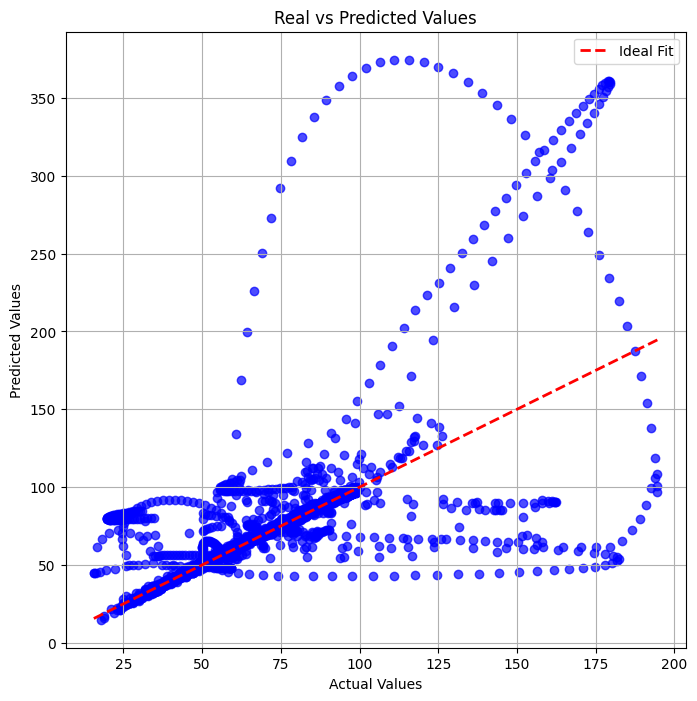

In [65]:
plot_real_vs_predicted(y_umid_test_flat, y_umid_pred_flat, save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\mlp_umid_real_x_pred_jacarepagua.png')


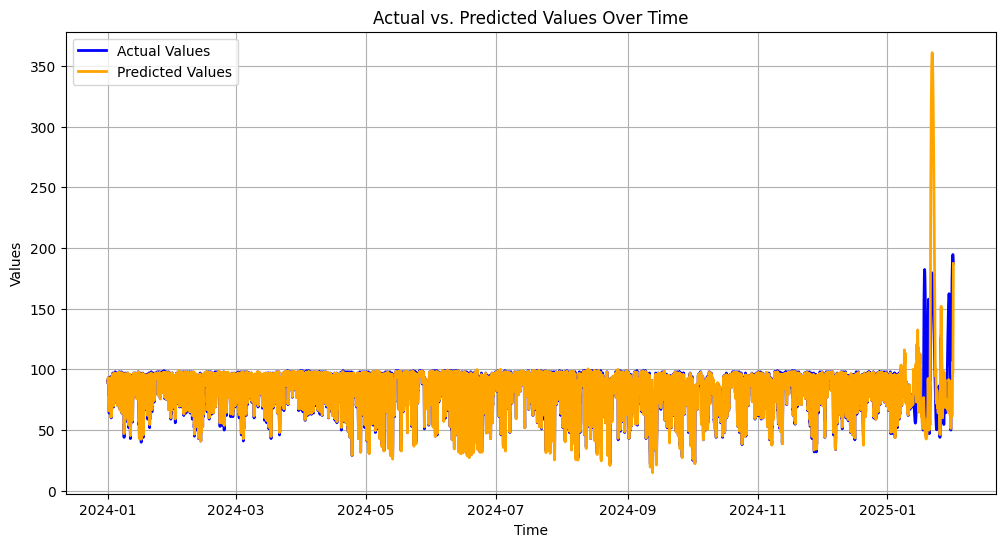

In [67]:
start_date = "2024-01-01 01:00:00"
end_date = "2025-01-31 23:00:00"

timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["datetime"]

plot_prediction_over_time(y_umid_test_flat, y_umid_pred_flat, timestamps_test, start_date, end_date,  save=r'C:\Users\F8091795\OneDrive - TIM\Pictures\mlp_umid_real_x_pred_jacarepagua_2024-2025.png')